In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import duckdb
from mpl_toolkits import mplot3d 
from mpl_toolkits.mplot3d import Axes3D

In [2]:
periodo = 365
USE_CUMSUM = True
year_list = ['2017','2018','2019','2022','2023']
#year_list_str = '(2017,2018,2019)'
year_list_str = '(2017,2018,2019,2022,2023)'
#year_list_str = '(2022,2023)'

In [3]:
#read data from parquet file
#number of days from the beginning of the year to consider in the analysis

common_filter = """
FROM datos_urgencia_consolidados.parquet
where IdCausa in (3,4,5,6,10,11)
and CodigoDependencia in (9,10,11,12,13,14)
and CodigoRegion is not null
--and GLOSATIPOESTABLECIMIENTO = 'Hospital'
--and CodigoRegion = 13
and year(strptime(fecha, '%d/%m/%Y')) in """ + year_list_str + """
group by CodigoDependencia, fecha, TipoEstablecimiento
""" + """
having dayofyear(strptime(fecha, '%d/%m/%Y')) <= """+ str(periodo) + """
"""

#here CodigoDependencia indicates the "Servicio de Salud"
#to ignote the grouping by "region"  set "CodigoRegion" to a constant and remove it from the group by
df2 = duckdb.sql("""
select year(strptime(fecha, '%d/%m/%Y')) as year
    , CodigoDependencia  as CodigoRegion
    , IF(GLOSATIPOESTABLECIMIENTO=='Hospital' , 'Hospital','NoHospital') as TipoEstablecimiento
    , dayofyear(strptime(fecha, '%d/%m/%Y')) as nrodia
    , 'pediatricos' as grupo_etario
    , sum(Menores_1) + sum(De_1_a_4) + sum(De_5_a_14) as atenciones
"""+ common_filter + """
UNION
select year(strptime(fecha, '%d/%m/%Y')) as year
    , CodigoDependencia  as CodigoRegion
    , IF(GLOSATIPOESTABLECIMIENTO=='Hospital' , 'Hospital','NoHospital') as TipoEstablecimiento
    , dayofyear(strptime(fecha, '%d/%m/%Y')) as nrodia
    ,'adultos' as grupo_etario
    , sum(De_15_a_64)  + sum(De_65_y_mas) as atenciones
"""+ common_filter + """
""").df()

df2 = df2.sort_values(by=['year','CodigoRegion', 'TipoEstablecimiento','grupo_etario','nrodia']).reset_index(drop = True)

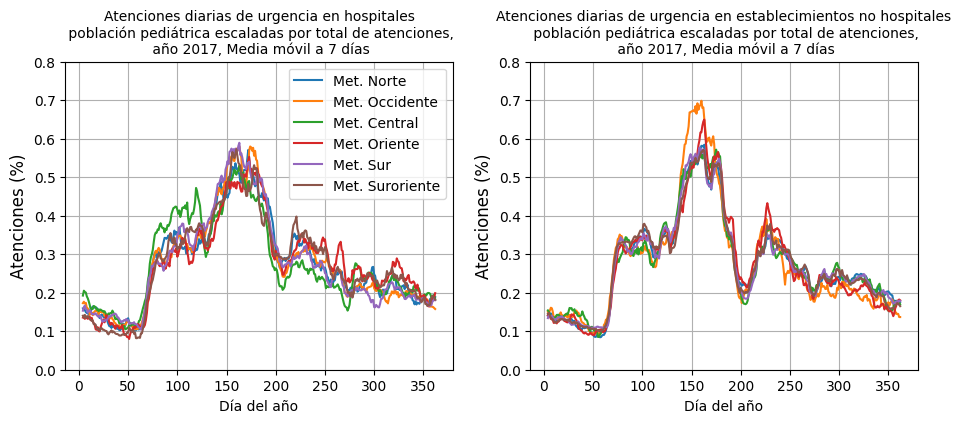

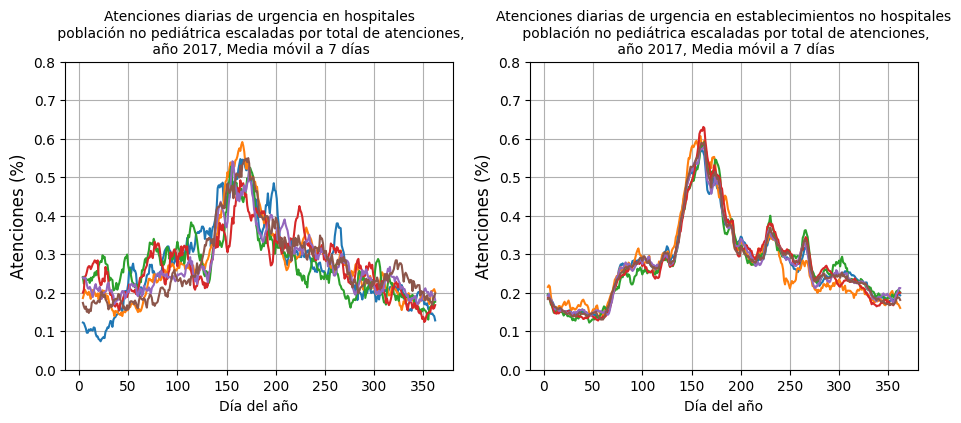

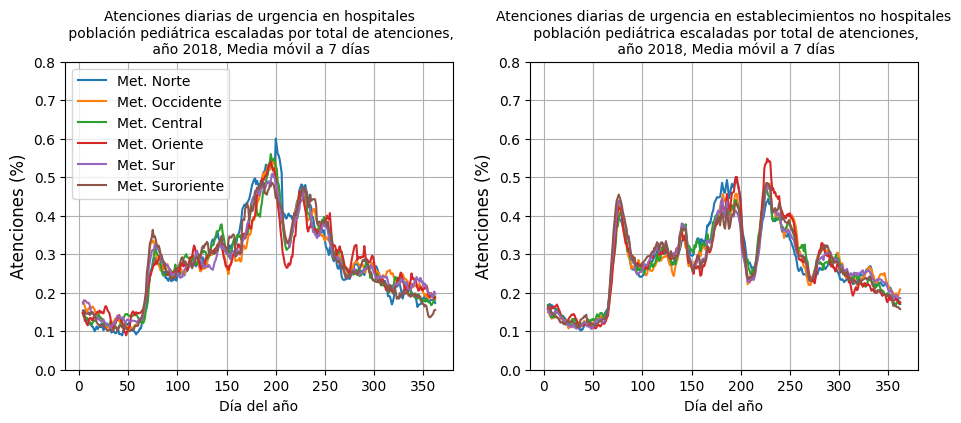

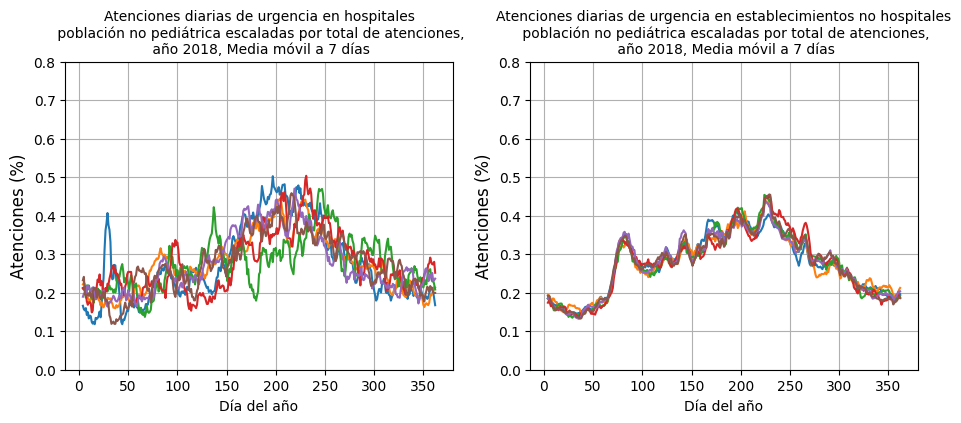

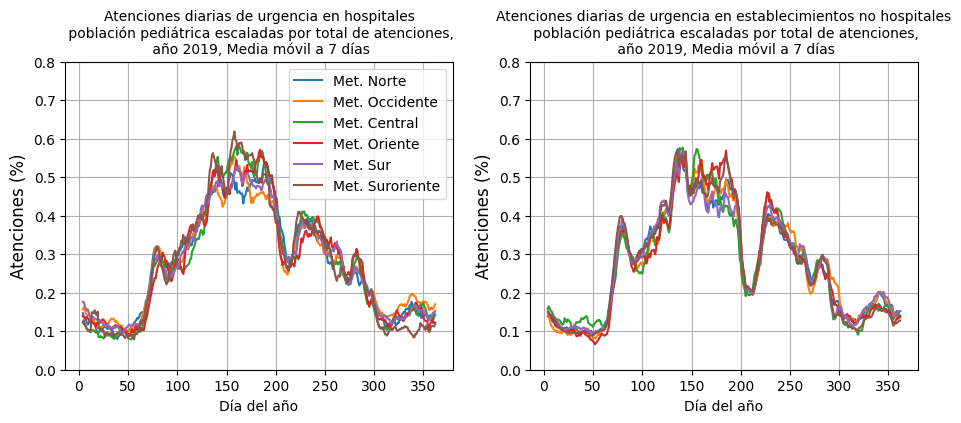

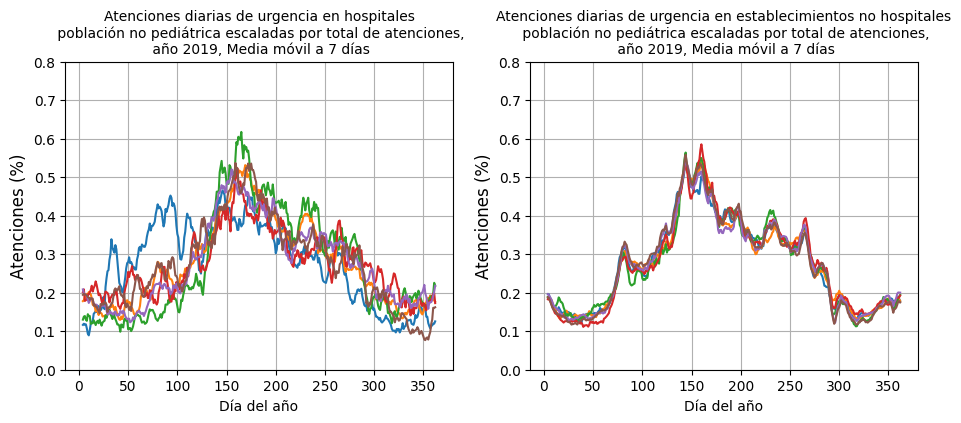

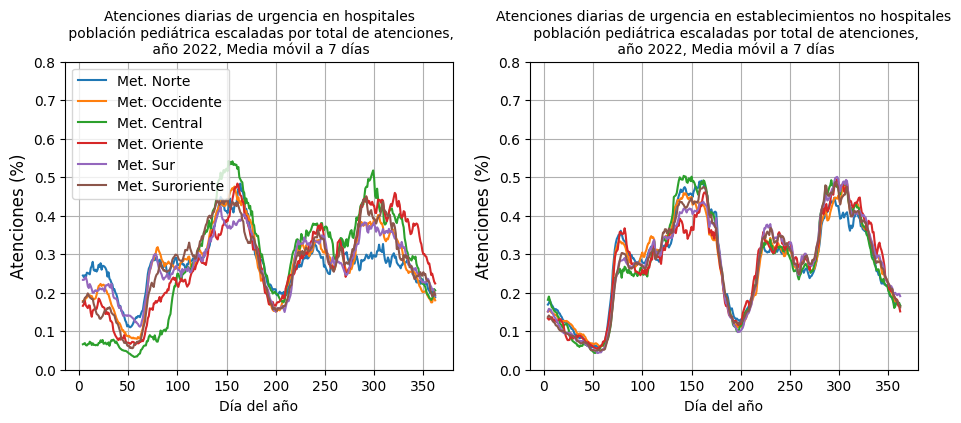

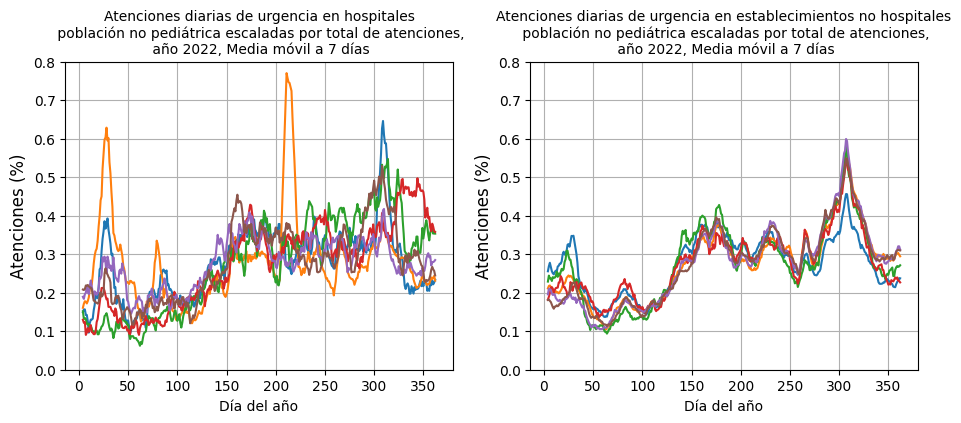

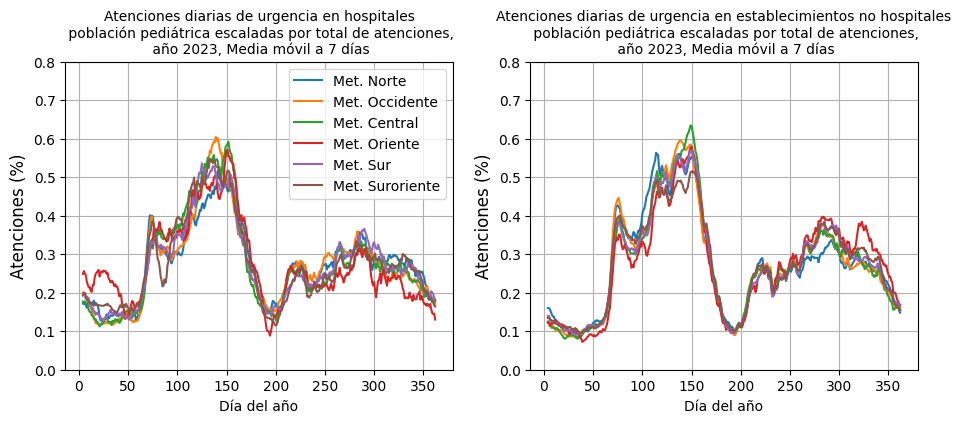

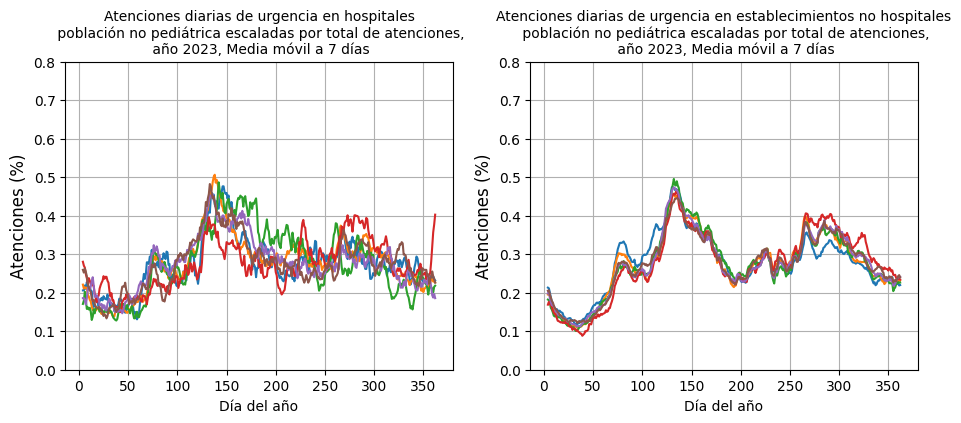

In [4]:
#Comparacion de datos para diferentes grupos etarios para un año fijo
#Full average: Goal to compare populations across years, 
#ages and locations by trying to stablish a baseline reference demand.
#WE scale the data dividing by the total yearly demand in order to distinguish behaviour

for k in range(5):
    year_figure = year_list[k]
    
    df = duckdb.sql("""
    select 
          year(strptime(fecha, '%d/%m/%Y')) as year
        , dayofyear(strptime(fecha, '%d/%m/%Y')) as nrodia
        , CodigoDependencia
        , IF(GLOSATIPOESTABLECIMIENTO=='Hospital' , 'Hospital','NoHospital') as TipoEstablecimiento
        , sum(Menores_1) as Menores_1
        , sum(De_1_a_4) as De_1_a_4
        , sum(De_5_a_14) as De_5_a_14
        , sum(De_15_a_64) as De_15_a_64
        , sum(De_65_y_mas) as De_65_y_mas
        , sum(Menores_1) + sum(De_1_a_4) + sum(De_5_a_14) as pediatricos
        , sum(De_15_a_64) + sum(De_65_y_mas) as adultos
    --    , sum(Menores_1) + sum(De_1_a_4)+ sum(De_5_a_14) + sum(De_15_a_64) + sum(De_65_y_mas) as atenciones
    FROM datos_urgencia_consolidados.parquet
    where IdCausa in (3,4,5,6,10,11) 
    and CodigoDependencia in (9,10,11,12,13,14)
    and fecha like '%""" + year_figure + """'
    group by year, CodigoDependencia, nrodia, TipoEstablecimiento
    order by year, CodigoDependencia, TipoEstablecimiento, nrodia
    """).df()
    
    fig = plt.figure(figsize = (11,4))
    ax = fig.add_subplot(1,2,1) 
    targets = ["pediatricos"]
    lista_servicios_salud = [9,10,11,12,13,14]
    etiquetas_servicios_salud = ['Met. Norte', 'Met. Occidente','Met. Central',
    'Met. Oriente', 'Met. Sur', 'Met. Suroriente']
    
    ax.set_prop_cycle(color = plt.get_cmap("tab10").colors)
    for servicio_salud in [9,10,11,12,13,14]:
        for column in targets:
            filtro_filas = (df["CodigoDependencia"]==servicio_salud) & (df["TipoEstablecimiento"]== 'Hospital')
            plt.plot(df.loc[filtro_filas,'nrodia'],100*df.loc[filtro_filas,column].rolling(7,center=True).mean()/float(sum(df.loc[filtro_filas,column]))) # c = color)
    plt.legend(etiquetas_servicios_salud)
    ax.grid()
    ax.set_title('Atenciones diarias de urgencia en hospitales\n población pediátrica escaladas por total de atenciones,\n año ' + year_figure + ', Media móvil a 7 días', fontsize = 10)
    ax.set_xlabel('Día del año', fontsize = 10)
    ax.set_ylabel('Atenciones (%)', fontsize = 12)
    ax.set_ylim(ymin=0)
    ax.set_ylim(ymax=0.8)
    
    ax = fig.add_subplot(1,2,2) 
    ax.set_prop_cycle(color = plt.get_cmap("tab10").colors)
    for servicio_salud in [9,10,11,12,13,14]:
        for column in targets:
            filtro_filas = (df["CodigoDependencia"]==servicio_salud) & (df["TipoEstablecimiento"] == 'NoHospital')
            plt.plot(df.loc[filtro_filas,'nrodia'],100*df.loc[filtro_filas,column].rolling(7,center=True).mean()/float(sum(df.loc[filtro_filas,column]))) # c = color)
    ax.grid()
    ax.set_title('Atenciones diarias de urgencia en establecimientos no hospitales\n población pediátrica escaladas por total de atenciones,\n año ' + year_figure + ', Media móvil a 7 días', fontsize = 10)
    ax.set_xlabel('Día del año', fontsize = 10)
    ax.set_ylabel('Atenciones (%)', fontsize = 12)
    ax.set_ylim(ymin=0)
    ax.set_ylim(ymax=0.8)
    
    plt.savefig('fig' + str(10 + k)+ '_ped_'+year_figure+ '.png', bbox_inches='tight')
    
    
    fig = plt.figure(figsize = (11,4))
    ax = fig.add_subplot(1,2,1) 
    targets = ["adultos"]
    lista_servicios_salud = [9,10,11,12,13,14]
    etiquetas_servicios_salud = ['Met. Norte', 'Met. Occidente','Met. Central',
    'Met. Oriente', 'Met. Sur', 'Met. Suroriente']
    
    ax.set_prop_cycle(color = plt.get_cmap("tab10").colors)
    for servicio_salud in [9,10,11,12,13,14]:
        for column in targets:
            filtro_filas = (df["CodigoDependencia"]==servicio_salud) & (df["TipoEstablecimiento"]== 'Hospital')
            plt.plot(df.loc[filtro_filas,'nrodia'],100*df.loc[filtro_filas,column].rolling(7,center=True).mean()/float(sum(df.loc[filtro_filas,column]))) # c = color)
    ax.grid()
    ax.set_title('Atenciones diarias de urgencia en hospitales\n población no pediátrica escaladas por total de atenciones,\n año ' + year_figure + ', Media móvil a 7 días', fontsize = 10)
    ax.set_xlabel('Día del año', fontsize = 10)
    ax.set_ylabel('Atenciones (%)', fontsize = 12)
    ax.set_ylim(ymin=0)
    ax.set_ylim(ymax=0.8)
    
    
    ax = fig.add_subplot(1,2,2) 
    ax.set_prop_cycle(color = plt.get_cmap("tab10").colors)
    for servicio_salud in [9,10,11,12,13,14]:
        for column in targets:
            filtro_filas = (df["CodigoDependencia"]==servicio_salud) & (df["TipoEstablecimiento"] == 'NoHospital')
            plt.plot(df.loc[filtro_filas,'nrodia'],100*df.loc[filtro_filas,column].rolling(7,center=True).mean()/float(sum(df.loc[filtro_filas,column]))) # c = color)
    ax.grid()
    ax.set_title('Atenciones diarias de urgencia en establecimientos no hospitales\n población no pediátrica escaladas por total de atenciones,\n año ' + year_figure + ', Media móvil a 7 días', fontsize = 10)
    ax.set_xlabel('Día del año', fontsize = 10)
    ax.set_ylabel('Atenciones (%)', fontsize = 12)
    ax.set_ylim(ymin=0)
    ax.set_ylim(ymax=0.8)
    plt.savefig('fig' + str(10 + k)+ '_noped_'+year_figure+ '.png', bbox_inches='tight')



#plt.show()